In [1]:
import ast
import folium
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import Counter
from folium.plugins import MarkerCluster

# Configure plots for inline display (if using Jupyter)
%matplotlib inline

### Inspecting training data

In [2]:
# Load CSV files
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")
taxonomy_df = pd.read_csv("/kaggle/input/birdclef-2025/taxonomy.csv")
sample_submission = pd.read_csv("/kaggle/input/birdclef-2025/sample_submission.csv")

# Load location metadata from the text file
with open("/kaggle/input/birdclef-2025/recording_location.txt", "r") as f:
    recording_location = f.read()

print("Train data shape:", train_df.shape)
print("Taxonomy data shape:", taxonomy_df.shape)
print("Sample submission shape:", sample_submission.shape)

Train data shape: (28564, 13)
Taxonomy data shape: (206, 5)
Sample submission shape: (3, 207)


**Key Findings:**  
- The train dataset has 28,564 rows and 13 columns.  
- Taxonomy data includes 206 species across 5 columns.  
- The sample submission file contains 3 rows and 207 columns.  
- Location metadata is loaded successfully from the text file.

### Missing Values & Duplicates

In [3]:
# Check for missing values
print(train_df.info())
print('\n',train_df.isnull().sum())

# Check for duplicates
print('\n',"Duplicates in train.csv:", train_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   secondary_labels  28564 non-null  object 
 2   type              28564 non-null  object 
 3   filename          28564 non-null  object 
 4   collection        28564 non-null  object 
 5   rating            28564 non-null  float64
 6   url               28564 non-null  object 
 7   latitude          27755 non-null  float64
 8   longitude         27755 non-null  float64
 9   scientific_name   28564 non-null  object 
 10  common_name       28564 non-null  object 
 11  author            28564 non-null  object 
 12  license           28564 non-null  object 
dtypes: float64(3), object(10)
memory usage: 2.8+ MB
None

 primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating


**Key Findings:**  
- All columns are complete except for `latitude` and `longitude`, which have 809 missing values each.  
- No duplicate records were found, ensuring data integrity.

### Primary Species Distribution

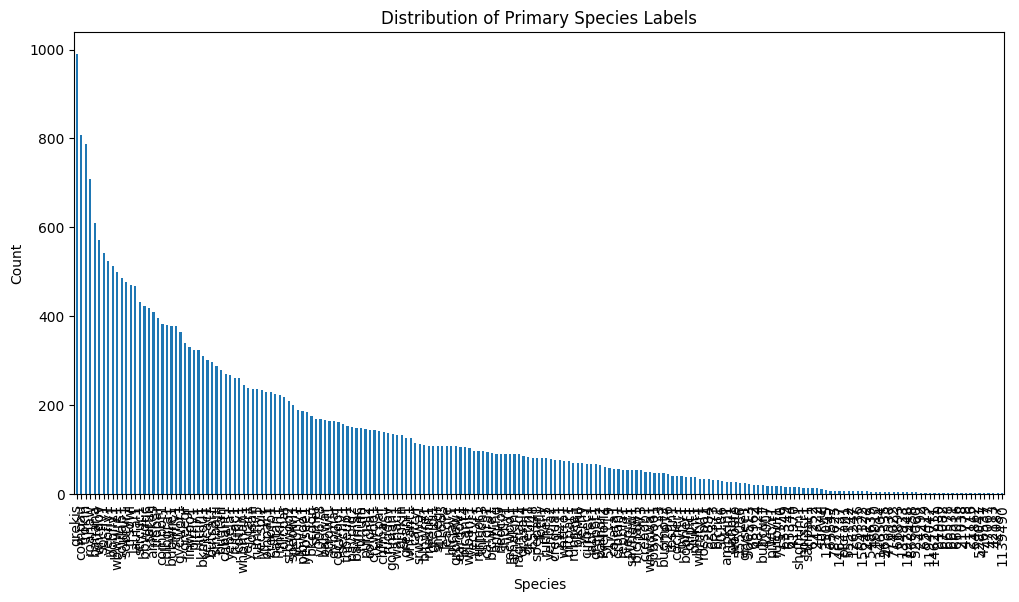

In [4]:
plt.figure(figsize=(12,6))
train_df['primary_label'].value_counts().plot(kind='bar')
plt.title("Distribution of Primary Species Labels")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

**Key Findings:**  
- The distribution is highly imbalanced with a few species dominating the counts.  - This imbalance may require special handling during modeling to account for rare classes.

### Audio Quality Ratings Distribution

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


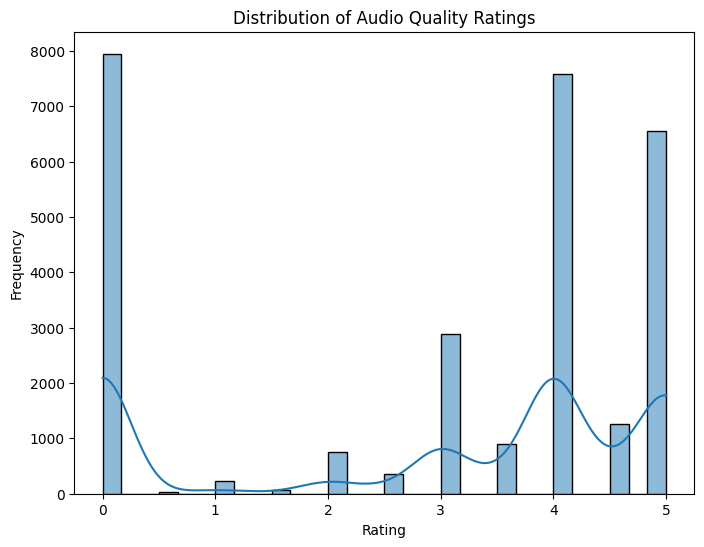

In [5]:
plt.figure(figsize=(8,6))
sns.histplot(train_df['rating'], bins=30, kde=True)
plt.title("Distribution of Audio Quality Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

**Key Findings:**  
- Ratings are mostly concentrated within a specific range.  
- The kernel density estimate (KDE) confirms a consistent distribution, indicating similar audio quality across recordings.

### Average Rating by Species

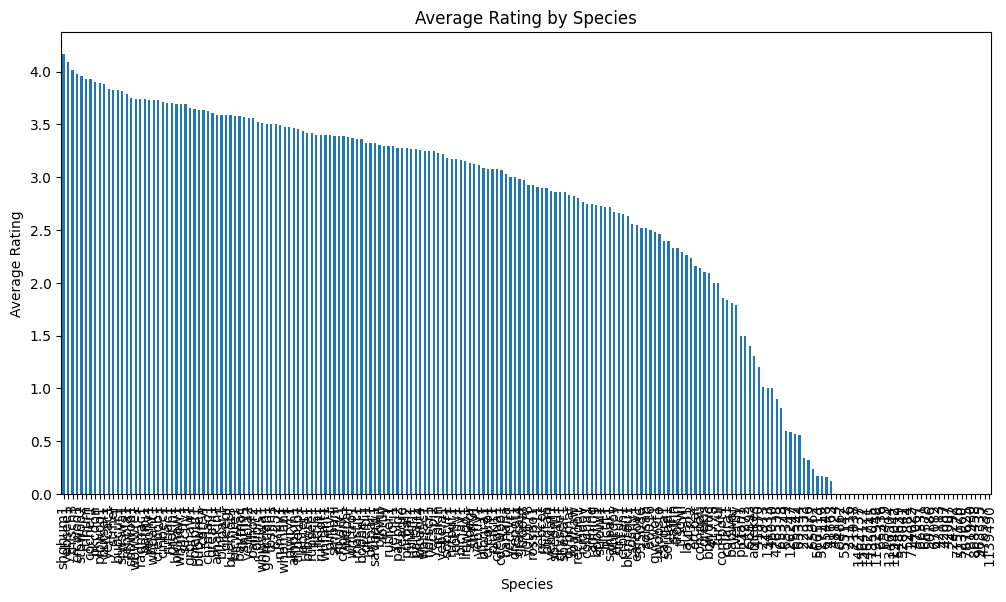

In [7]:
avg_rating_by_species = train_df.groupby('primary_label')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
avg_rating_by_species.plot(kind='bar')
plt.title("Average Rating by Species")
plt.xlabel("Species")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()

**Key Findings:**  
- Average ratings differ among species, indicating which species tend to have higher or lower quality recordings.  
- This insight is valuable for prioritizing species during further analysis or model development.

### Secondary Labels Analysis

In [9]:
# Convert secondary_labels from string to list and flatten the results
secondary_labels_list = []
for label in train_df['secondary_labels']:
    try:
        parsed = ast.literal_eval(label) if label and label != "[]" else []
    except:
        parsed = []
    secondary_labels_list.extend(parsed)

secondary_counter = Counter(secondary_labels_list)
print("Most common secondary labels:", secondary_counter.most_common(10))

Most common secondary labels: [('', 25885), ('grekis', 489), ('whtdov', 309), ('trokin', 188), ('soulap1', 114), ('pirfly1', 112), ('rugdov', 110), ('banana', 104), ('saffin', 102), ('yebela1', 96)]


**Key Findings:**  
- A high frequency of empty entries suggests secondary labels might be under-reported or inconsistently provided.

### Taxonomic Classes Distribution

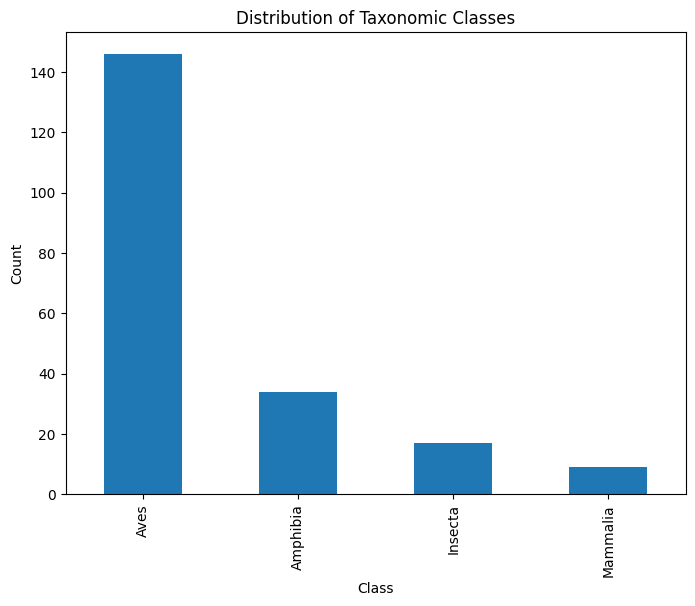

In [10]:
plt.figure(figsize=(8,6))
taxonomy_df['class_name'].value_counts().plot(kind='bar')
plt.title("Distribution of Taxonomic Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Key Findings:**  
- The bar chart illustrates the diversity of taxonomic classes in the dataset.  
- This helps understand the overall taxonomic spread and focus areas.

### Outlier Detection – Geographical Outliers

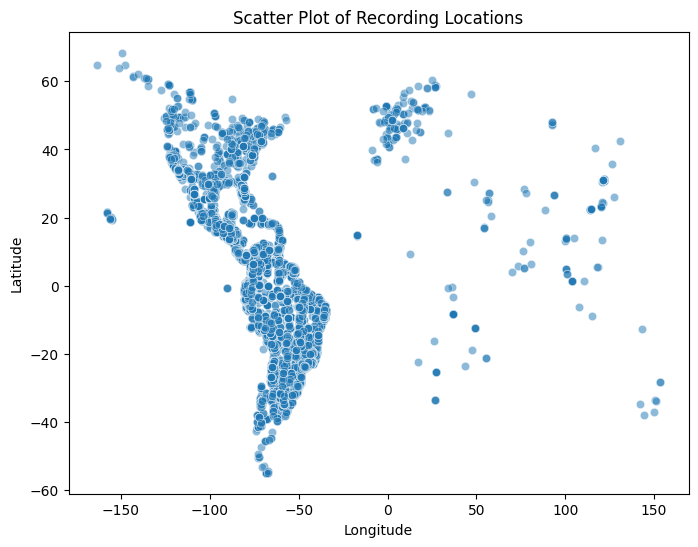

Latitude bounds: -51.98 - 46.40
Longitude bounds: -118.42 - -15.03
Number of geographical outliers: 514
Sample geographical outliers:
     latitude  longitude
297   49.1523     2.3752
312   48.7247  -122.3529
314   46.8702  -109.2880
315   47.4701  -122.6372
317   49.6044  -117.1258


In [13]:
# Remove rows with missing coordinate values
location_data = train_df.dropna(subset=['latitude', 'longitude'])

# Scatterplot of recording locations
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', data=location_data, alpha=0.5)
plt.title("Scatter Plot of Recording Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Calculate IQR for latitude
lat_Q1 = location_data['latitude'].quantile(0.25)
lat_Q3 = location_data['latitude'].quantile(0.75)
lat_IQR = lat_Q3 - lat_Q1
lat_lower_bound = lat_Q1 - 1.5 * lat_IQR
lat_upper_bound = lat_Q3 + 1.5 * lat_IQR

# Calculate IQR for longitude
lon_Q1 = location_data['longitude'].quantile(0.25)
lon_Q3 = location_data['longitude'].quantile(0.75)
lon_IQR = lon_Q3 - lon_Q1
lon_lower_bound = lon_Q1 - 1.5 * lon_IQR
lon_upper_bound = lon_Q3 + 1.5 * lon_IQR

print(f"Latitude bounds: {lat_lower_bound:.2f} - {lat_upper_bound:.2f}")
print(f"Longitude bounds: {lon_lower_bound:.2f} - {lon_upper_bound:.2f}")

# Identify geographical outliers
geo_outliers = location_data[
    (location_data['latitude'] < lat_lower_bound) | (location_data['latitude'] > lat_upper_bound) |
    (location_data['longitude'] < lon_lower_bound) | (location_data['longitude'] > lon_upper_bound)
]
print("Number of geographical outliers:", geo_outliers.shape[0])
print("Sample geographical outliers:")
print(geo_outliers[['latitude', 'longitude']].head())

**Key Findings:**  
- Recordings are spread over a wide geographic area.  
- Some outlier locations are visible, suggesting further investigation may be needed.
- The scatterplot shows a broad geographic spread.  
- The IQR method identifies 514 geographical outlier points, suggesting some recordings are far outside the main cluster.

### Data Imbalance – Collection Bias

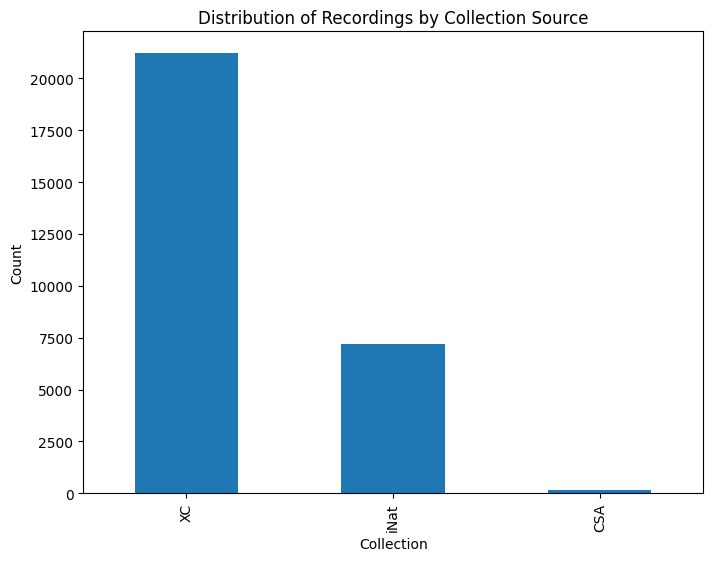

Collection counts:
collection
XC      21204
iNat     7198
CSA       162
Name: count, dtype: int64


In [16]:
collection_counts = train_df['collection'].value_counts()
plt.figure(figsize=(8, 6))
collection_counts.plot(kind='bar')
plt.title("Distribution of Recordings by Collection Source")
plt.xlabel("Collection")
plt.ylabel("Count")
plt.show()

print("Collection counts:")
print(collection_counts)

**Key Findings:**  
- Average ratings differ among species, indicating which species tend to have higher or lower quality recordings.  
- This insight is valuable for prioritizing species during further analysis or model development.
- The "XC" collection dominates the dataset with over 21,000 recordings.  
- This imbalance may affect model performance and should be accounted for during preprocessing.